In [1]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_0_layer.pth'

/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Only extract hidden states
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[1].mean(dim=1).cpu().numpy())
    return np.vstack(hidden_states)

In [4]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:06<00:00,  3.48it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [01:22<00:00,  2.94it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=4096 and hidden_dim=256


Training Epochs:   0%|          | 9/2000 [00:03<07:04,  4.69it/s]/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

Epoch 10/2000, Loss: 0.6897
Test Accuracy at Epoch 10: 48.95%
Test F1-score at Epoch 10: 0.6572
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00       194
non_infringement       0.49      1.00      0.66       186

        accuracy                           0.49       380
       macro avg       0.24      0.50      0.33       380
    weighted avg       0.24      0.49      0.32       380

New best model saved with F1-score 0.6572 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00       194
non_infringement       0.49      1.00      0.66       186

        accuracy                           0.49       380
       macro avg       0.24      0.50      0.33       380
    weighted avg       0.24      0.49      0.32       380



Training Epochs:   1%|          | 20/2000 [00:10<21:59,  1.50it/s]

Epoch 20/2000, Loss: 0.6763
Test Accuracy at Epoch 20: 56.32%
Test F1-score at Epoch 20: 0.6157
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.60      0.42      0.49       194
non_infringement       0.54      0.72      0.62       186

        accuracy                           0.56       380
       macro avg       0.57      0.57      0.55       380
    weighted avg       0.57      0.56      0.55       380



Training Epochs:   2%|▏         | 30/2000 [00:16<21:41,  1.51it/s]

Epoch 30/2000, Loss: 0.6585
Test Accuracy at Epoch 30: 53.42%
Test F1-score at Epoch 30: 0.3610
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.53      0.79      0.63       194
non_infringement       0.55      0.27      0.36       186

        accuracy                           0.53       380
       macro avg       0.54      0.53      0.50       380
    weighted avg       0.54      0.53      0.50       380



Training Epochs:   2%|▏         | 40/2000 [00:23<21:50,  1.50it/s]

Epoch 40/2000, Loss: 0.6341
Test Accuracy at Epoch 40: 56.05%
Test F1-score at Epoch 40: 0.4595
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.55      0.73      0.63       194
non_infringement       0.58      0.38      0.46       186

        accuracy                           0.56       380
       macro avg       0.56      0.56      0.54       380
    weighted avg       0.56      0.56      0.55       380



Training Epochs:   2%|▎         | 50/2000 [00:29<20:24,  1.59it/s]

Epoch 50/2000, Loss: 0.5899
Test Accuracy at Epoch 50: 56.84%
Test F1-score at Epoch 50: 0.5060
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.56      0.68      0.62       194
non_infringement       0.58      0.45      0.51       186

        accuracy                           0.57       380
       macro avg       0.57      0.57      0.56       380
    weighted avg       0.57      0.57      0.56       380



Training Epochs:   3%|▎         | 60/2000 [00:34<15:08,  2.14it/s]

Epoch 60/2000, Loss: 0.5384
Test Accuracy at Epoch 60: 67.89%
Test F1-score at Epoch 60: 0.6823
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.70      0.65      0.68       194
non_infringement       0.66      0.70      0.68       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380

New best model saved with F1-score 0.6823 at epoch 60
Best Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.70      0.65      0.68       194
non_infringement       0.66      0.70      0.68       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:   4%|▎         | 70/2000 [00:39<13:48,  2.33it/s]

Epoch 70/2000, Loss: 0.4863
Test Accuracy at Epoch 70: 69.47%
Test F1-score at Epoch 70: 0.7184
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.65      0.80      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.71      0.69      0.69       380

New best model saved with F1-score 0.7184 at epoch 70
Best Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.65      0.80      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.71      0.69      0.69       380



Training Epochs:   4%|▍         | 80/2000 [00:41<09:00,  3.55it/s]

Epoch 80/2000, Loss: 0.4364
Test Accuracy at Epoch 80: 69.21%
Test F1-score at Epoch 80: 0.7194
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.76      0.58      0.66       194
non_infringement       0.65      0.81      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.71      0.69      0.69       380

New best model saved with F1-score 0.7194 at epoch 80
Best Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.76      0.58      0.66       194
non_infringement       0.65      0.81      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.71      0.69      0.69       380



Training Epochs:   4%|▍         | 90/2000 [00:46<11:37,  2.74it/s]

Epoch 90/2000, Loss: 0.3968
Test Accuracy at Epoch 90: 72.37%
Test F1-score at Epoch 90: 0.7445
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.79      0.63      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380

New best model saved with F1-score 0.7445 at epoch 90
Best Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.79      0.63      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:   5%|▍         | 97/2000 [00:49<12:13,  2.60it/s]

Epoch 100/2000, Loss: 0.3704
Test Accuracy at Epoch 100: 73.16%
Test F1-score at Epoch 100: 0.7560
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.81      0.62      0.70       194
non_infringement       0.68      0.85      0.76       186

        accuracy                           0.73       380
       macro avg       0.75      0.73      0.73       380
    weighted avg       0.75      0.73      0.73       380



Training Epochs:   5%|▌         | 100/2000 [00:49<10:11,  3.11it/s]

New best model saved with F1-score 0.7560 at epoch 100
Best Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.81      0.62      0.70       194
non_infringement       0.68      0.85      0.76       186

        accuracy                           0.73       380
       macro avg       0.75      0.73      0.73       380
    weighted avg       0.75      0.73      0.73       380



Training Epochs:   6%|▌         | 110/2000 [00:55<17:47,  1.77it/s]

Epoch 110/2000, Loss: 0.3522
Test Accuracy at Epoch 110: 76.84%
Test F1-score at Epoch 110: 0.7833
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.83      0.69      0.75       194
non_infringement       0.72      0.85      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380

New best model saved with F1-score 0.7833 at epoch 110
Best Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.83      0.69      0.75       194
non_infringement       0.72      0.85      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:   6%|▌         | 120/2000 [00:59<14:05,  2.22it/s]

Epoch 120/2000, Loss: 0.3403
Test Accuracy at Epoch 120: 77.63%
Test F1-score at Epoch 120: 0.7922
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.85      0.69      0.76       194
non_infringement       0.73      0.87      0.79       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.77       380

New best model saved with F1-score 0.7922 at epoch 120
Best Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.85      0.69      0.76       194
non_infringement       0.73      0.87      0.79       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.77       380



Training Epochs:   6%|▋         | 130/2000 [01:03<10:03,  3.10it/s]

Epoch 130/2000, Loss: 0.3309
Test Accuracy at Epoch 130: 77.63%
Test F1-score at Epoch 130: 0.7922
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.85      0.69      0.76       194
non_infringement       0.73      0.87      0.79       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.77       380



Training Epochs:   7%|▋         | 140/2000 [01:07<09:30,  3.26it/s]

Epoch 140/2000, Loss: 0.3223
Test Accuracy at Epoch 140: 77.89%
Test F1-score at Epoch 140: 0.7941
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.85      0.69      0.76       194
non_infringement       0.73      0.87      0.79       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380

New best model saved with F1-score 0.7941 at epoch 140
Best Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.85      0.69      0.76       194
non_infringement       0.73      0.87      0.79       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:   8%|▊         | 153/2000 [01:10<04:58,  6.20it/s]

Epoch 150/2000, Loss: 0.3141
Test Accuracy at Epoch 150: 77.37%
Test F1-score at Epoch 150: 0.7882
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.84      0.69      0.76       194
non_infringement       0.73      0.86      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.78      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:   8%|▊         | 162/2000 [01:10<02:52, 10.67it/s]

Epoch 160/2000, Loss: 0.3058
Test Accuracy at Epoch 160: 77.37%
Test F1-score at Epoch 160: 0.7882
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.84      0.69      0.76       194
non_infringement       0.73      0.86      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.78      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:   8%|▊         | 170/2000 [01:11<05:07,  5.95it/s]

Epoch 170/2000, Loss: 0.2974
Test Accuracy at Epoch 170: 77.37%
Test F1-score at Epoch 170: 0.7882
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.84      0.69      0.76       194
non_infringement       0.73      0.86      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.78      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:   9%|▉         | 179/2000 [01:12<02:40, 11.33it/s]

Epoch 180/2000, Loss: 0.2903
Test Accuracy at Epoch 180: 77.63%
Test F1-score at Epoch 180: 0.7891
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.83      0.70      0.76       194
non_infringement       0.73      0.85      0.79       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  10%|▉         | 190/2000 [01:13<02:28, 12.15it/s]

Epoch 190/2000, Loss: 0.2818
Test Accuracy at Epoch 190: 78.16%
Test F1-score at Epoch 190: 0.7971
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.85      0.69      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380

New best model saved with F1-score 0.7971 at epoch 190
Best Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.85      0.69      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  10%|▉         | 199/2000 [01:16<10:27,  2.87it/s]

Epoch 200/2000, Loss: 0.2744
Test Accuracy at Epoch 200: 78.42%
Test F1-score at Epoch 200: 0.7980
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.85      0.70      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.79      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  10%|█         | 200/2000 [01:17<13:30,  2.22it/s]

New best model saved with F1-score 0.7980 at epoch 200
Best Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.85      0.70      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.79      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  10%|█         | 210/2000 [01:19<05:18,  5.62it/s]

Epoch 210/2000, Loss: 0.2665
Test Accuracy at Epoch 210: 78.16%
Test F1-score at Epoch 210: 0.7951
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.84      0.70      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  11%|█         | 220/2000 [01:22<10:08,  2.93it/s]

Epoch 220/2000, Loss: 0.2588
Test Accuracy at Epoch 220: 76.84%
Test F1-score at Epoch 220: 0.7885
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.85      0.66      0.74       194
non_infringement       0.71      0.88      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  12%|█▏        | 231/2000 [01:23<02:53, 10.22it/s]

Epoch 230/2000, Loss: 0.2506
Test Accuracy at Epoch 230: 76.58%
Test F1-score at Epoch 230: 0.7845
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.84      0.66      0.74       194
non_infringement       0.71      0.87      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.77      0.76       380



Training Epochs:  12%|█▏        | 240/2000 [01:24<03:11,  9.18it/s]

Epoch 240/2000, Loss: 0.2428
Test Accuracy at Epoch 240: 77.11%
Test F1-score at Epoch 240: 0.7904
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.85      0.66      0.75       194
non_infringement       0.72      0.88      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.77      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  12%|█▏        | 249/2000 [01:25<01:49, 16.05it/s]

Epoch 250/2000, Loss: 0.2355
Test Accuracy at Epoch 250: 76.58%
Test F1-score at Epoch 250: 0.7835
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.84      0.67      0.74       194
non_infringement       0.72      0.87      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.77      0.76       380



Training Epochs:  13%|█▎        | 262/2000 [01:27<02:59,  9.68it/s]

Epoch 260/2000, Loss: 0.2279
Test Accuracy at Epoch 260: 76.84%
Test F1-score at Epoch 260: 0.7874
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.85      0.66      0.75       194
non_infringement       0.71      0.88      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  14%|█▍        | 276/2000 [01:28<01:25, 20.21it/s]

Epoch 270/2000, Loss: 0.2204
Test Accuracy at Epoch 270: 77.11%
Test F1-score at Epoch 270: 0.7893
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.85      0.67      0.75       194
non_infringement       0.72      0.88      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  14%|█▍        | 279/2000 [01:28<01:51, 15.40it/s]

Epoch 280/2000, Loss: 0.2135
Test Accuracy at Epoch 280: 76.84%
Test F1-score at Epoch 280: 0.7874
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.85      0.66      0.75       194
non_infringement       0.71      0.88      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  15%|█▍        | 292/2000 [01:30<02:39, 10.72it/s]

Epoch 290/2000, Loss: 0.2063
Test Accuracy at Epoch 290: 78.42%
Test F1-score at Epoch 290: 0.7980
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.85      0.70      0.77       194
non_infringement       0.74      0.87      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.79      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  15%|█▍        | 299/2000 [01:30<01:51, 15.27it/s]

Epoch 300/2000, Loss: 0.2008
Test Accuracy at Epoch 300: 77.89%
Test F1-score at Epoch 300: 0.7941
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.85      0.69      0.76       194
non_infringement       0.73      0.87      0.79       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  16%|█▌        | 316/2000 [01:31<01:27, 19.26it/s]

Epoch 310/2000, Loss: 0.1943
Test Accuracy at Epoch 310: 80.00%
Test F1-score at Epoch 310: 0.8109
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.86      0.73      0.79       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380

New best model saved with F1-score 0.8109 at epoch 310
Best Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.86      0.73      0.79       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  16%|█▋        | 325/2000 [01:32<01:01, 27.41it/s]

Epoch 320/2000, Loss: 0.1877
Test Accuracy at Epoch 320: 80.00%
Test F1-score at Epoch 320: 0.8109
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.86      0.73      0.79       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  16%|█▋        | 330/2000 [01:32<00:53, 31.37it/s]

Epoch 330/2000, Loss: 0.1821
Test Accuracy at Epoch 330: 78.42%
Test F1-score at Epoch 330: 0.8000
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  17%|█▋        | 340/2000 [01:33<03:38,  7.61it/s]

Epoch 340/2000, Loss: 0.1764
Test Accuracy at Epoch 340: 78.16%
Test F1-score at Epoch 340: 0.7971
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.85      0.69      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  18%|█▊        | 350/2000 [01:39<13:21,  2.06it/s]

Epoch 350/2000, Loss: 0.1727
Test Accuracy at Epoch 350: 78.16%
Test F1-score at Epoch 350: 0.7981
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  18%|█▊        | 360/2000 [01:42<10:34,  2.58it/s]

Epoch 360/2000, Loss: 0.1695
Test Accuracy at Epoch 360: 78.16%
Test F1-score at Epoch 360: 0.7981
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  19%|█▊        | 372/2000 [01:45<06:46,  4.01it/s]

Epoch 370/2000, Loss: 0.1646
Test Accuracy at Epoch 370: 78.16%
Test F1-score at Epoch 370: 0.7971
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.85      0.69      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  19%|█▉        | 380/2000 [01:48<11:55,  2.26it/s]

Epoch 380/2000, Loss: 0.1601
Test Accuracy at Epoch 380: 78.16%
Test F1-score at Epoch 380: 0.7971
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.85      0.69      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  20%|█▉        | 390/2000 [01:54<15:47,  1.70it/s]

Epoch 390/2000, Loss: 0.1567
Test Accuracy at Epoch 390: 78.16%
Test F1-score at Epoch 390: 0.7971
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.85      0.69      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  20%|██        | 400/2000 [01:57<06:30,  4.10it/s]

Epoch 400/2000, Loss: 0.1535
Test Accuracy at Epoch 400: 78.42%
Test F1-score at Epoch 400: 0.8000
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  20%|██        | 410/2000 [02:01<12:17,  2.16it/s]

Epoch 410/2000, Loss: 0.1506
Test Accuracy at Epoch 410: 78.42%
Test F1-score at Epoch 410: 0.8000
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  21%|██        | 420/2000 [02:07<14:36,  1.80it/s]

Epoch 420/2000, Loss: 0.1478
Test Accuracy at Epoch 420: 78.42%
Test F1-score at Epoch 420: 0.8000
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  22%|██▏       | 430/2000 [02:11<10:05,  2.59it/s]

Epoch 430/2000, Loss: 0.1452
Test Accuracy at Epoch 430: 78.42%
Test F1-score at Epoch 430: 0.8000
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  22%|██▏       | 440/2000 [02:17<15:16,  1.70it/s]

Epoch 440/2000, Loss: 0.1427
Test Accuracy at Epoch 440: 78.42%
Test F1-score at Epoch 440: 0.8000
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  22%|██▎       | 450/2000 [02:22<13:30,  1.91it/s]

Epoch 450/2000, Loss: 0.1403
Test Accuracy at Epoch 450: 78.95%
Test F1-score at Epoch 450: 0.8058
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  23%|██▎       | 460/2000 [02:26<12:53,  1.99it/s]

Epoch 460/2000, Loss: 0.1382
Test Accuracy at Epoch 460: 78.95%
Test F1-score at Epoch 460: 0.8058
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  24%|██▎       | 470/2000 [02:31<10:27,  2.44it/s]

Epoch 470/2000, Loss: 0.1418
Test Accuracy at Epoch 470: 80.26%
Test F1-score at Epoch 470: 0.8139
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.87      0.73      0.79       194
non_infringement       0.76      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380

New best model saved with F1-score 0.8139 at epoch 470
Best Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.87      0.73      0.79       194
non_infringement       0.76      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  24%|██▍       | 482/2000 [02:34<04:01,  6.29it/s]

Epoch 480/2000, Loss: 0.1346
Test Accuracy at Epoch 480: 78.95%
Test F1-score at Epoch 480: 0.8058
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  24%|██▍       | 490/2000 [02:36<03:50,  6.54it/s]

Epoch 490/2000, Loss: 0.1339
Test Accuracy at Epoch 490: 78.95%
Test F1-score at Epoch 490: 0.8058
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  25%|██▍       | 499/2000 [02:39<07:34,  3.30it/s]

Epoch 500/2000, Loss: 0.1321
Test Accuracy at Epoch 500: 78.42%
Test F1-score at Epoch 500: 0.8000
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  26%|██▌       | 511/2000 [02:42<03:56,  6.31it/s]

Epoch 510/2000, Loss: 0.1307
Test Accuracy at Epoch 510: 78.95%
Test F1-score at Epoch 510: 0.8058
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  26%|██▌       | 520/2000 [02:46<12:11,  2.02it/s]

Epoch 520/2000, Loss: 0.1295
Test Accuracy at Epoch 520: 78.95%
Test F1-score at Epoch 520: 0.8058
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  26%|██▋       | 528/2000 [02:47<03:05,  7.94it/s]

Epoch 530/2000, Loss: 0.1284
Test Accuracy at Epoch 530: 78.95%
Test F1-score at Epoch 530: 0.8058
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  27%|██▋       | 539/2000 [02:48<01:39, 14.71it/s]

Epoch 540/2000, Loss: 0.1273
Test Accuracy at Epoch 540: 78.95%
Test F1-score at Epoch 540: 0.8058
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  28%|██▊       | 550/2000 [02:51<04:29,  5.37it/s]

Epoch 550/2000, Loss: 0.1262
Test Accuracy at Epoch 550: 78.95%
Test F1-score at Epoch 550: 0.8058
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  28%|██▊       | 560/2000 [02:53<03:16,  7.32it/s]

Epoch 560/2000, Loss: 0.1252
Test Accuracy at Epoch 560: 78.95%
Test F1-score at Epoch 560: 0.8058
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  28%|██▊       | 570/2000 [02:58<12:15,  1.94it/s]

Epoch 570/2000, Loss: 0.1243
Test Accuracy at Epoch 570: 78.95%
Test F1-score at Epoch 570: 0.8058
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  29%|██▉       | 580/2000 [03:03<14:14,  1.66it/s]

Epoch 580/2000, Loss: 0.1233
Test Accuracy at Epoch 580: 78.95%
Test F1-score at Epoch 580: 0.8058
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  30%|██▉       | 590/2000 [03:06<09:11,  2.56it/s]

Epoch 590/2000, Loss: 0.1224
Test Accuracy at Epoch 590: 78.95%
Test F1-score at Epoch 590: 0.8058
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  30%|███       | 600/2000 [03:08<02:41,  8.65it/s]

Epoch 600/2000, Loss: 0.1261
Test Accuracy at Epoch 600: 78.42%
Test F1-score at Epoch 600: 0.8019
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  30%|███       | 610/2000 [03:11<06:09,  3.77it/s]

Epoch 610/2000, Loss: 0.1219
Test Accuracy at Epoch 610: 78.95%
Test F1-score at Epoch 610: 0.8058
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  31%|███       | 620/2000 [03:14<04:51,  4.74it/s]

Epoch 620/2000, Loss: 0.1202
Test Accuracy at Epoch 620: 80.00%
Test F1-score at Epoch 620: 0.8119
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.86      0.72      0.79       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  31%|███▏      | 629/2000 [03:17<04:09,  5.50it/s]

Epoch 630/2000, Loss: 0.1198
Test Accuracy at Epoch 630: 78.42%
Test F1-score at Epoch 630: 0.8000
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  32%|███▏      | 640/2000 [03:22<11:25,  1.98it/s]

Epoch 640/2000, Loss: 0.1191
Test Accuracy at Epoch 640: 78.16%
Test F1-score at Epoch 640: 0.7981
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  33%|███▎      | 652/2000 [03:26<03:41,  6.08it/s]

Epoch 650/2000, Loss: 0.1184
Test Accuracy at Epoch 650: 78.16%
Test F1-score at Epoch 650: 0.7981
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  33%|███▎      | 660/2000 [03:30<11:17,  1.98it/s]

Epoch 660/2000, Loss: 0.1178
Test Accuracy at Epoch 660: 78.16%
Test F1-score at Epoch 660: 0.7981
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  34%|███▎      | 671/2000 [03:32<03:39,  6.05it/s]

Epoch 670/2000, Loss: 0.1173
Test Accuracy at Epoch 670: 78.16%
Test F1-score at Epoch 670: 0.7981
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  34%|███▍      | 680/2000 [03:37<10:40,  2.06it/s]

Epoch 680/2000, Loss: 0.1167
Test Accuracy at Epoch 680: 78.16%
Test F1-score at Epoch 680: 0.7981
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  35%|███▍      | 692/2000 [03:39<03:43,  5.85it/s]

Epoch 690/2000, Loss: 0.1162
Test Accuracy at Epoch 690: 78.16%
Test F1-score at Epoch 690: 0.7981
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  35%|███▌      | 700/2000 [03:42<09:12,  2.35it/s]

Epoch 700/2000, Loss: 0.1156
Test Accuracy at Epoch 700: 79.74%
Test F1-score at Epoch 700: 0.8099
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.86      0.72      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  36%|███▌      | 710/2000 [03:46<06:18,  3.41it/s]

Epoch 710/2000, Loss: 0.1151
Test Accuracy at Epoch 710: 79.74%
Test F1-score at Epoch 710: 0.8099
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.86      0.72      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  36%|███▌      | 723/2000 [03:48<01:35, 13.37it/s]

Epoch 720/2000, Loss: 0.1146
Test Accuracy at Epoch 720: 79.74%
Test F1-score at Epoch 720: 0.8099
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.86      0.72      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  36%|███▋      | 730/2000 [03:49<02:31,  8.36it/s]

Epoch 730/2000, Loss: 0.1176
Test Accuracy at Epoch 730: 81.84%
Test F1-score at Epoch 730: 0.8262
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.87      0.76      0.81       194
non_infringement       0.78      0.88      0.83       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.82      0.82      0.82       380

New best model saved with F1-score 0.8262 at epoch 730
Best Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.87      0.76      0.81       194
non_infringement       0.78      0.88      0.83       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.82      0.82      0.82       380



Training Epochs:  37%|███▋      | 740/2000 [03:51<05:48,  3.61it/s]

Epoch 740/2000, Loss: 0.1143
Test Accuracy at Epoch 740: 81.58%
Test F1-score at Epoch 740: 0.8241
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.87      0.75      0.81       194
non_infringement       0.77      0.88      0.82       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.82      0.82      0.82       380



Training Epochs:  38%|███▊      | 750/2000 [03:54<08:40,  2.40it/s]

Epoch 750/2000, Loss: 0.1148
Test Accuracy at Epoch 750: 79.74%
Test F1-score at Epoch 750: 0.8099
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.86      0.72      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  38%|███▊      | 760/2000 [04:00<11:30,  1.80it/s]

Epoch 760/2000, Loss: 0.1131
Test Accuracy at Epoch 760: 78.42%
Test F1-score at Epoch 760: 0.8019
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.87      0.68      0.76       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  39%|███▊      | 771/2000 [04:03<04:14,  4.83it/s]

Epoch 770/2000, Loss: 0.1129
Test Accuracy at Epoch 770: 79.47%
Test F1-score at Epoch 770: 0.8079
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.86      0.71      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.80      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  39%|███▉      | 780/2000 [04:05<03:02,  6.67it/s]

Epoch 780/2000, Loss: 0.1124
Test Accuracy at Epoch 780: 79.74%
Test F1-score at Epoch 780: 0.8099
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.86      0.72      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  40%|███▉      | 790/2000 [04:09<08:34,  2.35it/s]

Epoch 790/2000, Loss: 0.1120
Test Accuracy at Epoch 790: 79.74%
Test F1-score at Epoch 790: 0.8099
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.86      0.72      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  40%|████      | 800/2000 [04:14<11:15,  1.78it/s]

Epoch 800/2000, Loss: 0.1117
Test Accuracy at Epoch 800: 79.74%
Test F1-score at Epoch 800: 0.8099
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.86      0.72      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  41%|████      | 811/2000 [04:16<02:46,  7.13it/s]

Epoch 810/2000, Loss: 0.1114
Test Accuracy at Epoch 810: 79.74%
Test F1-score at Epoch 810: 0.8099
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.86      0.72      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  41%|████      | 820/2000 [04:19<07:12,  2.73it/s]

Epoch 820/2000, Loss: 0.1110
Test Accuracy at Epoch 820: 79.74%
Test F1-score at Epoch 820: 0.8099
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.86      0.72      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  42%|████▏     | 830/2000 [04:22<07:30,  2.60it/s]

Epoch 830/2000, Loss: 0.1107
Test Accuracy at Epoch 830: 79.74%
Test F1-score at Epoch 830: 0.8099
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.86      0.72      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  42%|████▏     | 840/2000 [04:24<02:30,  7.69it/s]

Epoch 840/2000, Loss: 0.1104
Test Accuracy at Epoch 840: 79.74%
Test F1-score at Epoch 840: 0.8099
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.86      0.72      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  42%|████▎     | 850/2000 [04:29<10:06,  1.90it/s]

Epoch 850/2000, Loss: 0.1101
Test Accuracy at Epoch 850: 79.74%
Test F1-score at Epoch 850: 0.8099
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.86      0.72      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  43%|████▎     | 860/2000 [04:31<04:45,  3.99it/s]

Epoch 860/2000, Loss: 0.1098
Test Accuracy at Epoch 860: 79.74%
Test F1-score at Epoch 860: 0.8099
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.86      0.72      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  44%|████▎     | 870/2000 [04:33<02:53,  6.52it/s]

Epoch 870/2000, Loss: 0.1095
Test Accuracy at Epoch 870: 79.74%
Test F1-score at Epoch 870: 0.8099
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.86      0.72      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  44%|████▍     | 881/2000 [04:37<05:19,  3.50it/s]

Epoch 880/2000, Loss: 0.1092
Test Accuracy at Epoch 880: 79.47%
Test F1-score at Epoch 880: 0.8069
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.86      0.72      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.80      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  44%|████▍     | 889/2000 [04:38<02:00,  9.24it/s]

Epoch 890/2000, Loss: 0.1090
Test Accuracy at Epoch 890: 78.95%
Test F1-score at Epoch 890: 0.8030
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.86      0.71      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  45%|████▌     | 903/2000 [04:40<01:52,  9.74it/s]

Epoch 900/2000, Loss: 0.1126
Test Accuracy at Epoch 900: 77.63%
Test F1-score at Epoch 900: 0.7981
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.88      0.65      0.75       194
non_infringement       0.71      0.90      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.78      0.77       380
    weighted avg       0.80      0.78      0.77       380



Training Epochs:  46%|████▌     | 913/2000 [04:41<01:31, 11.92it/s]

Epoch 910/2000, Loss: 0.1085
Test Accuracy at Epoch 910: 78.68%
Test F1-score at Epoch 910: 0.8029
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  46%|████▌     | 920/2000 [04:42<02:00,  8.94it/s]

Epoch 920/2000, Loss: 0.1083
Test Accuracy at Epoch 920: 78.68%
Test F1-score at Epoch 920: 0.8010
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  47%|████▋     | 932/2000 [04:45<02:48,  6.33it/s]

Epoch 930/2000, Loss: 0.1080
Test Accuracy at Epoch 930: 78.68%
Test F1-score at Epoch 930: 0.8010
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  47%|████▋     | 940/2000 [04:45<01:22, 12.82it/s]

Epoch 940/2000, Loss: 0.1078
Test Accuracy at Epoch 940: 78.95%
Test F1-score at Epoch 940: 0.8030
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.86      0.71      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  48%|████▊     | 952/2000 [04:46<01:27, 12.04it/s]

Epoch 950/2000, Loss: 0.1076
Test Accuracy at Epoch 950: 78.95%
Test F1-score at Epoch 950: 0.8030
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.86      0.71      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  48%|████▊     | 964/2000 [04:47<00:52, 19.91it/s]

Epoch 960/2000, Loss: 0.1074
Test Accuracy at Epoch 960: 78.95%
Test F1-score at Epoch 960: 0.8030
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.86      0.71      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  49%|████▊     | 974/2000 [04:47<00:43, 23.58it/s]

Epoch 970/2000, Loss: 0.1072
Test Accuracy at Epoch 970: 78.68%
Test F1-score at Epoch 970: 0.8020
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  49%|████▉     | 984/2000 [04:47<00:43, 23.54it/s]

Epoch 980/2000, Loss: 0.1070
Test Accuracy at Epoch 980: 78.68%
Test F1-score at Epoch 980: 0.8020
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  50%|████▉     | 993/2000 [04:48<00:46, 21.70it/s]

Epoch 990/2000, Loss: 0.1068
Test Accuracy at Epoch 990: 78.68%
Test F1-score at Epoch 990: 0.8020
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  50%|█████     | 1001/2000 [04:49<01:12, 13.86it/s]

Epoch 1000/2000, Loss: 0.1066
Test Accuracy at Epoch 1000: 78.68%
Test F1-score at Epoch 1000: 0.8020
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  50%|█████     | 1010/2000 [04:51<04:17,  3.85it/s]

Epoch 1010/2000, Loss: 0.1064
Test Accuracy at Epoch 1010: 78.68%
Test F1-score at Epoch 1010: 0.8020
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  51%|█████     | 1024/2000 [04:52<01:03, 15.42it/s]

Epoch 1020/2000, Loss: 0.1062
Test Accuracy at Epoch 1020: 78.68%
Test F1-score at Epoch 1020: 0.8020
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  52%|█████▏    | 1031/2000 [04:53<00:59, 16.19it/s]

Epoch 1030/2000, Loss: 0.1060
Test Accuracy at Epoch 1030: 77.89%
Test F1-score at Epoch 1030: 0.7961
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.86      0.68      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  52%|█████▏    | 1040/2000 [04:54<01:37,  9.86it/s]

Epoch 1040/2000, Loss: 0.1080
Test Accuracy at Epoch 1040: 76.84%
Test F1-score at Epoch 1040: 0.7915
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.87      0.64      0.74       194
non_infringement       0.71      0.90      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.77      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  53%|█████▎    | 1054/2000 [04:55<00:57, 16.58it/s]

Epoch 1050/2000, Loss: 0.1079
Test Accuracy at Epoch 1050: 79.47%
Test F1-score at Epoch 1050: 0.8079
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.86      0.71      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.80      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  53%|█████▎    | 1064/2000 [04:55<00:41, 22.61it/s]

Epoch 1060/2000, Loss: 0.1061
Test Accuracy at Epoch 1060: 80.79%
Test F1-score at Epoch 1060: 0.8180
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.87      0.74      0.80       194
non_infringement       0.76      0.88      0.82       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:  54%|█████▍    | 1075/2000 [04:55<00:26, 35.50it/s]

Epoch 1070/2000, Loss: 0.1054
Test Accuracy at Epoch 1070: 78.68%
Test F1-score at Epoch 1070: 0.8020
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  54%|█████▍    | 1085/2000 [04:55<00:26, 35.12it/s]

Epoch 1080/2000, Loss: 0.1053
Test Accuracy at Epoch 1080: 77.89%
Test F1-score at Epoch 1080: 0.7961
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.86      0.68      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  55%|█████▍    | 1094/2000 [04:56<00:29, 31.15it/s]

Epoch 1090/2000, Loss: 0.1051
Test Accuracy at Epoch 1090: 77.89%
Test F1-score at Epoch 1090: 0.7961
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.86      0.68      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  55%|█████▍    | 1099/2000 [04:56<00:26, 34.29it/s]

Epoch 1100/2000, Loss: 0.1049
Test Accuracy at Epoch 1100: 78.68%
Test F1-score at Epoch 1100: 0.8020
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  56%|█████▌    | 1112/2000 [04:57<01:00, 14.65it/s]

Epoch 1110/2000, Loss: 0.1048
Test Accuracy at Epoch 1110: 78.68%
Test F1-score at Epoch 1110: 0.8020
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  56%|█████▌    | 1120/2000 [04:59<02:28,  5.94it/s]

Epoch 1120/2000, Loss: 0.1046
Test Accuracy at Epoch 1120: 78.68%
Test F1-score at Epoch 1120: 0.8020
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  57%|█████▋    | 1132/2000 [05:00<01:31,  9.45it/s]

Epoch 1130/2000, Loss: 0.1045
Test Accuracy at Epoch 1130: 78.68%
Test F1-score at Epoch 1130: 0.8020
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  57%|█████▋    | 1142/2000 [05:01<01:00, 14.14it/s]

Epoch 1140/2000, Loss: 0.1043
Test Accuracy at Epoch 1140: 78.68%
Test F1-score at Epoch 1140: 0.8020
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  58%|█████▊    | 1155/2000 [05:01<00:31, 26.55it/s]

Epoch 1150/2000, Loss: 0.1042
Test Accuracy at Epoch 1150: 78.68%
Test F1-score at Epoch 1150: 0.8020
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  58%|█████▊    | 1162/2000 [05:01<00:31, 26.76it/s]

Epoch 1160/2000, Loss: 0.1041
Test Accuracy at Epoch 1160: 78.68%
Test F1-score at Epoch 1160: 0.8020
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  59%|█████▉    | 1177/2000 [05:01<00:21, 38.49it/s]

Epoch 1170/2000, Loss: 0.1074
Test Accuracy at Epoch 1170: 80.79%
Test F1-score at Epoch 1170: 0.8180
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.87      0.74      0.80       194
non_infringement       0.76      0.88      0.82       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380

Epoch 1180/2000, Loss: 0.1046
Test Accuracy at Epoch 1180: 78.42%
Test F1-score at Epoch 1180: 0.8000
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  60%|█████▉    | 1190/2000 [05:06<03:15,  4.14it/s]

Epoch 1190/2000, Loss: 0.1038
Test Accuracy at Epoch 1190: 78.16%
Test F1-score at Epoch 1190: 0.7981
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  60%|██████    | 1200/2000 [05:11<05:56,  2.24it/s]

Epoch 1200/2000, Loss: 0.1038
Test Accuracy at Epoch 1200: 78.68%
Test F1-score at Epoch 1200: 0.8020
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  60%|██████    | 1209/2000 [05:12<01:47,  7.37it/s]

Epoch 1210/2000, Loss: 0.1035
Test Accuracy at Epoch 1210: 78.68%
Test F1-score at Epoch 1210: 0.8020
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  61%|██████    | 1219/2000 [05:13<01:34,  8.24it/s]

Epoch 1220/2000, Loss: 0.1034
Test Accuracy at Epoch 1220: 78.68%
Test F1-score at Epoch 1220: 0.8020
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  62%|██████▏   | 1230/2000 [05:16<04:34,  2.81it/s]

Epoch 1230/2000, Loss: 0.1033
Test Accuracy at Epoch 1230: 78.68%
Test F1-score at Epoch 1230: 0.8020
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  62%|██████▏   | 1240/2000 [05:20<04:01,  3.14it/s]

Epoch 1240/2000, Loss: 0.1032
Test Accuracy at Epoch 1240: 78.68%
Test F1-score at Epoch 1240: 0.8020
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  63%|██████▎   | 1253/2000 [05:21<01:07, 11.08it/s]

Epoch 1250/2000, Loss: 0.1031
Test Accuracy at Epoch 1250: 78.68%
Test F1-score at Epoch 1250: 0.8020
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  63%|██████▎   | 1260/2000 [05:25<04:43,  2.61it/s]

Epoch 1260/2000, Loss: 0.1029
Test Accuracy at Epoch 1260: 78.68%
Test F1-score at Epoch 1260: 0.8020
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  64%|██████▎   | 1273/2000 [05:28<01:38,  7.39it/s]

Epoch 1270/2000, Loss: 0.1028
Test Accuracy at Epoch 1270: 78.68%
Test F1-score at Epoch 1270: 0.8020
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  64%|██████▍   | 1280/2000 [05:29<01:34,  7.64it/s]

Epoch 1280/2000, Loss: 0.1027
Test Accuracy at Epoch 1280: 78.68%
Test F1-score at Epoch 1280: 0.8020
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  64%|██████▍   | 1289/2000 [05:32<03:06,  3.81it/s]

Epoch 1290/2000, Loss: 0.1038
Test Accuracy at Epoch 1290: 76.84%
Test F1-score at Epoch 1290: 0.7895
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.86      0.65      0.74       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  65%|██████▌   | 1302/2000 [05:33<00:54, 12.82it/s]

Epoch 1300/2000, Loss: 0.1073
Test Accuracy at Epoch 1300: 80.79%
Test F1-score at Epoch 1300: 0.8180
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.87      0.74      0.80       194
non_infringement       0.76      0.88      0.82       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:  66%|██████▌   | 1310/2000 [05:33<00:35, 19.48it/s]

Epoch 1310/2000, Loss: 0.1042
Test Accuracy at Epoch 1310: 80.53%
Test F1-score at Epoch 1310: 0.8159
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.87      0.73      0.79       194
non_infringement       0.76      0.88      0.82       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.80       380
    weighted avg       0.81      0.81      0.80       380



Training Epochs:  66%|██████▌   | 1321/2000 [05:35<01:17,  8.75it/s]

Epoch 1320/2000, Loss: 0.1030
Test Accuracy at Epoch 1320: 78.68%
Test F1-score at Epoch 1320: 0.8020
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  66%|██████▋   | 1330/2000 [05:39<05:03,  2.21it/s]

Epoch 1330/2000, Loss: 0.1025
Test Accuracy at Epoch 1330: 78.68%
Test F1-score at Epoch 1330: 0.8020
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  67%|██████▋   | 1340/2000 [05:44<06:20,  1.74it/s]

Epoch 1340/2000, Loss: 0.1023
Test Accuracy at Epoch 1340: 78.68%
Test F1-score at Epoch 1340: 0.8020
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  68%|██████▊   | 1351/2000 [05:46<01:31,  7.12it/s]

Epoch 1350/2000, Loss: 0.1022
Test Accuracy at Epoch 1350: 78.68%
Test F1-score at Epoch 1350: 0.8020
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  68%|██████▊   | 1359/2000 [05:47<00:47, 13.43it/s]

Epoch 1360/2000, Loss: 0.1021
Test Accuracy at Epoch 1360: 78.42%
Test F1-score at Epoch 1360: 0.8000
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  69%|██████▊   | 1371/2000 [05:49<01:24,  7.47it/s]

Epoch 1370/2000, Loss: 0.1020
Test Accuracy at Epoch 1370: 78.42%
Test F1-score at Epoch 1370: 0.8000
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  69%|██████▉   | 1380/2000 [05:53<05:00,  2.06it/s]

Epoch 1380/2000, Loss: 0.1019
Test Accuracy at Epoch 1380: 78.42%
Test F1-score at Epoch 1380: 0.8000
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  70%|██████▉   | 1390/2000 [05:54<01:10,  8.62it/s]

Epoch 1390/2000, Loss: 0.1018
Test Accuracy at Epoch 1390: 78.42%
Test F1-score at Epoch 1390: 0.8000
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  70%|███████   | 1401/2000 [05:56<01:00,  9.93it/s]

Epoch 1400/2000, Loss: 0.1018
Test Accuracy at Epoch 1400: 78.68%
Test F1-score at Epoch 1400: 0.8029
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  71%|███████   | 1411/2000 [06:00<03:24,  2.88it/s]

Epoch 1410/2000, Loss: 0.1017
Test Accuracy at Epoch 1410: 78.68%
Test F1-score at Epoch 1410: 0.8029
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  71%|███████   | 1420/2000 [06:02<02:36,  3.71it/s]

Epoch 1420/2000, Loss: 0.1016
Test Accuracy at Epoch 1420: 78.68%
Test F1-score at Epoch 1420: 0.8029
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  72%|███████▏  | 1430/2000 [06:06<04:40,  2.03it/s]

Epoch 1430/2000, Loss: 0.1015
Test Accuracy at Epoch 1430: 78.68%
Test F1-score at Epoch 1430: 0.8029
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  72%|███████▏  | 1444/2000 [06:10<01:17,  7.20it/s]

Epoch 1440/2000, Loss: 0.1015
Test Accuracy at Epoch 1440: 78.68%
Test F1-score at Epoch 1440: 0.8029
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  73%|███████▎  | 1451/2000 [06:10<00:41, 13.18it/s]

Epoch 1450/2000, Loss: 0.1014
Test Accuracy at Epoch 1450: 78.68%
Test F1-score at Epoch 1450: 0.8029
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  73%|███████▎  | 1460/2000 [06:10<00:31, 17.30it/s]

Epoch 1460/2000, Loss: 0.1013
Test Accuracy at Epoch 1460: 78.68%
Test F1-score at Epoch 1460: 0.8029
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  74%|███████▎  | 1471/2000 [06:15<02:14,  3.94it/s]

Epoch 1470/2000, Loss: 0.1013
Test Accuracy at Epoch 1470: 78.68%
Test F1-score at Epoch 1470: 0.8029
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  74%|███████▍  | 1482/2000 [06:15<00:40, 12.72it/s]

Epoch 1480/2000, Loss: 0.1015
Test Accuracy at Epoch 1480: 78.68%
Test F1-score at Epoch 1480: 0.8020
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  74%|███████▍  | 1489/2000 [06:16<00:34, 14.91it/s]

Epoch 1490/2000, Loss: 0.1013
Test Accuracy at Epoch 1490: 78.42%
Test F1-score at Epoch 1490: 0.8010
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.76       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  75%|███████▌  | 1502/2000 [06:20<01:26,  5.74it/s]

Epoch 1500/2000, Loss: 0.1029
Test Accuracy at Epoch 1500: 78.68%
Test F1-score at Epoch 1500: 0.8020
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.86      0.70      0.77       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  76%|███████▌  | 1512/2000 [06:21<00:34, 14.13it/s]

Epoch 1510/2000, Loss: 0.1016
Test Accuracy at Epoch 1510: 80.53%
Test F1-score at Epoch 1510: 0.8159
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.87      0.73      0.79       194
non_infringement       0.76      0.88      0.82       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.80       380
    weighted avg       0.81      0.81      0.80       380



Training Epochs:  76%|███████▌  | 1524/2000 [06:21<00:23, 20.40it/s]

Epoch 1520/2000, Loss: 0.1010
Test Accuracy at Epoch 1520: 78.68%
Test F1-score at Epoch 1520: 0.8029
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  77%|███████▋  | 1534/2000 [06:21<00:19, 23.46it/s]

Epoch 1530/2000, Loss: 0.1010
Test Accuracy at Epoch 1530: 78.42%
Test F1-score at Epoch 1530: 0.8010
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.76       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  77%|███████▋  | 1544/2000 [06:22<00:18, 24.44it/s]

Epoch 1540/2000, Loss: 0.1009
Test Accuracy at Epoch 1540: 78.42%
Test F1-score at Epoch 1540: 0.8010
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.76       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  78%|███████▊  | 1550/2000 [06:24<01:31,  4.92it/s]

Epoch 1550/2000, Loss: 0.1008
Test Accuracy at Epoch 1550: 78.68%
Test F1-score at Epoch 1550: 0.8029
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  78%|███████▊  | 1562/2000 [06:26<00:58,  7.47it/s]

Epoch 1560/2000, Loss: 0.1007
Test Accuracy at Epoch 1560: 78.68%
Test F1-score at Epoch 1560: 0.8029
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  79%|███████▊  | 1572/2000 [06:27<00:32, 13.34it/s]

Epoch 1570/2000, Loss: 0.1007
Test Accuracy at Epoch 1570: 78.42%
Test F1-score at Epoch 1570: 0.8010
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.76       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  79%|███████▉  | 1581/2000 [06:27<00:21, 19.29it/s]

Epoch 1580/2000, Loss: 0.1006
Test Accuracy at Epoch 1580: 78.68%
Test F1-score at Epoch 1580: 0.8029
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  80%|███████▉  | 1591/2000 [06:29<00:36, 11.06it/s]

Epoch 1590/2000, Loss: 0.1006
Test Accuracy at Epoch 1590: 78.68%
Test F1-score at Epoch 1590: 0.8029
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  80%|████████  | 1602/2000 [06:29<00:19, 19.94it/s]

Epoch 1600/2000, Loss: 0.1005
Test Accuracy at Epoch 1600: 78.68%
Test F1-score at Epoch 1600: 0.8029
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  81%|████████  | 1612/2000 [06:29<00:19, 20.02it/s]

Epoch 1610/2000, Loss: 0.1004
Test Accuracy at Epoch 1610: 79.21%
Test F1-score at Epoch 1610: 0.8087
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       194
non_infringement       0.74      0.90      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  81%|████████▏ | 1626/2000 [06:30<00:13, 26.79it/s]

Epoch 1620/2000, Loss: 0.1004
Test Accuracy at Epoch 1620: 79.21%
Test F1-score at Epoch 1620: 0.8087
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       194
non_infringement       0.74      0.90      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  82%|████████▏ | 1634/2000 [06:30<00:12, 29.02it/s]

Epoch 1630/2000, Loss: 0.1003
Test Accuracy at Epoch 1630: 79.21%
Test F1-score at Epoch 1630: 0.8087
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       194
non_infringement       0.74      0.90      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  82%|████████▏ | 1643/2000 [06:30<00:10, 35.54it/s]

Epoch 1640/2000, Loss: 0.1005
Test Accuracy at Epoch 1640: 78.42%
Test F1-score at Epoch 1640: 0.8000
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  83%|████████▎ | 1656/2000 [06:31<00:10, 32.27it/s]

Epoch 1650/2000, Loss: 0.1022
Test Accuracy at Epoch 1650: 78.42%
Test F1-score at Epoch 1650: 0.8000
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  83%|████████▎ | 1663/2000 [06:31<00:15, 21.61it/s]

Epoch 1660/2000, Loss: 0.1003
Test Accuracy at Epoch 1660: 78.42%
Test F1-score at Epoch 1660: 0.8000
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  84%|████████▎ | 1670/2000 [06:32<00:21, 15.60it/s]

Epoch 1670/2000, Loss: 0.1007
Test Accuracy at Epoch 1670: 78.95%
Test F1-score at Epoch 1670: 0.8068
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       194
non_infringement       0.73      0.90      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  84%|████████▍ | 1681/2000 [06:33<00:34,  9.22it/s]

Epoch 1680/2000, Loss: 0.1001
Test Accuracy at Epoch 1680: 79.21%
Test F1-score at Epoch 1680: 0.8087
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       194
non_infringement       0.74      0.90      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  85%|████████▍ | 1692/2000 [06:34<00:29, 10.52it/s]

Epoch 1690/2000, Loss: 0.1000
Test Accuracy at Epoch 1690: 78.95%
Test F1-score at Epoch 1690: 0.8058
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  85%|████████▌ | 1700/2000 [06:35<00:31,  9.66it/s]

Epoch 1700/2000, Loss: 0.1000
Test Accuracy at Epoch 1700: 78.95%
Test F1-score at Epoch 1700: 0.8068
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       194
non_infringement       0.73      0.90      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  86%|████████▌ | 1710/2000 [06:38<00:57,  5.02it/s]

Epoch 1710/2000, Loss: 0.1000
Test Accuracy at Epoch 1710: 78.95%
Test F1-score at Epoch 1710: 0.8058
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  86%|████████▌ | 1720/2000 [06:42<01:49,  2.55it/s]

Epoch 1720/2000, Loss: 0.0999
Test Accuracy at Epoch 1720: 78.95%
Test F1-score at Epoch 1720: 0.8068
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       194
non_infringement       0.73      0.90      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  87%|████████▋ | 1732/2000 [06:46<00:44,  6.07it/s]

Epoch 1730/2000, Loss: 0.0999
Test Accuracy at Epoch 1730: 78.95%
Test F1-score at Epoch 1730: 0.8058
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  87%|████████▋ | 1740/2000 [06:48<01:14,  3.48it/s]

Epoch 1740/2000, Loss: 0.0998
Test Accuracy at Epoch 1740: 78.95%
Test F1-score at Epoch 1740: 0.8058
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  88%|████████▊ | 1750/2000 [06:51<01:29,  2.78it/s]

Epoch 1750/2000, Loss: 0.0998
Test Accuracy at Epoch 1750: 78.95%
Test F1-score at Epoch 1750: 0.8058
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  88%|████████▊ | 1759/2000 [06:53<00:48,  4.95it/s]

Epoch 1760/2000, Loss: 0.0999
Test Accuracy at Epoch 1760: 78.95%
Test F1-score at Epoch 1760: 0.8058
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  88%|████████▊ | 1770/2000 [06:55<00:22, 10.42it/s]

Epoch 1770/2000, Loss: 0.1025
Test Accuracy at Epoch 1770: 80.53%
Test F1-score at Epoch 1770: 0.8159
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.87      0.73      0.79       194
non_infringement       0.76      0.88      0.82       186

        accuracy                           0.81       380
       macro avg       0.81      0.81      0.80       380
    weighted avg       0.81      0.81      0.80       380



Training Epochs:  89%|████████▉ | 1780/2000 [06:57<00:59,  3.68it/s]

Epoch 1780/2000, Loss: 0.1009
Test Accuracy at Epoch 1780: 78.95%
Test F1-score at Epoch 1780: 0.8068
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       194
non_infringement       0.73      0.90      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  89%|████████▉ | 1789/2000 [07:02<01:31,  2.30it/s]

Epoch 1790/2000, Loss: 0.1000
Test Accuracy at Epoch 1790: 78.95%
Test F1-score at Epoch 1790: 0.8058
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  90%|████████▉ | 1799/2000 [07:04<00:40,  5.02it/s]

Epoch 1800/2000, Loss: 0.0997
Test Accuracy at Epoch 1800: 78.68%
Test F1-score at Epoch 1800: 0.8039
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.78       380



Training Epochs:  91%|█████████ | 1812/2000 [07:05<00:15, 11.86it/s]

Epoch 1810/2000, Loss: 0.0996
Test Accuracy at Epoch 1810: 78.95%
Test F1-score at Epoch 1810: 0.8058
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  91%|█████████ | 1821/2000 [07:07<00:23,  7.69it/s]

Epoch 1820/2000, Loss: 0.0995
Test Accuracy at Epoch 1820: 78.68%
Test F1-score at Epoch 1820: 0.8039
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.78       380



Training Epochs:  92%|█████████▏| 1833/2000 [07:11<00:28,  5.86it/s]

Epoch 1830/2000, Loss: 0.0994
Test Accuracy at Epoch 1830: 78.68%
Test F1-score at Epoch 1830: 0.8039
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.78       380



Training Epochs:  92%|█████████▏| 1842/2000 [07:12<00:14, 11.00it/s]

Epoch 1840/2000, Loss: 0.0994
Test Accuracy at Epoch 1840: 78.95%
Test F1-score at Epoch 1840: 0.8058
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  92%|█████████▏| 1849/2000 [07:12<00:08, 16.87it/s]

Epoch 1850/2000, Loss: 0.0994
Test Accuracy at Epoch 1850: 78.95%
Test F1-score at Epoch 1850: 0.8058
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  93%|█████████▎| 1860/2000 [07:18<01:09,  2.02it/s]

Epoch 1860/2000, Loss: 0.1008
Test Accuracy at Epoch 1860: 80.26%
Test F1-score at Epoch 1860: 0.8139
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.87      0.73      0.79       194
non_infringement       0.76      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  94%|█████████▎| 1872/2000 [07:19<00:12,  9.87it/s]

Epoch 1870/2000, Loss: 0.0995
Test Accuracy at Epoch 1870: 78.68%
Test F1-score at Epoch 1870: 0.8039
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.78       380



Training Epochs:  94%|█████████▍| 1881/2000 [07:21<00:15,  7.47it/s]

Epoch 1880/2000, Loss: 0.0992
Test Accuracy at Epoch 1880: 78.95%
Test F1-score at Epoch 1880: 0.8058
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  95%|█████████▍| 1891/2000 [07:22<00:10, 10.82it/s]

Epoch 1890/2000, Loss: 0.0992
Test Accuracy at Epoch 1890: 78.68%
Test F1-score at Epoch 1890: 0.8039
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.78       380



Training Epochs:  95%|█████████▍| 1899/2000 [07:23<00:06, 15.67it/s]

Epoch 1900/2000, Loss: 0.0992
Test Accuracy at Epoch 1900: 78.68%
Test F1-score at Epoch 1900: 0.8039
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.78       380



Training Epochs:  96%|█████████▌| 1910/2000 [07:27<00:38,  2.36it/s]

Epoch 1910/2000, Loss: 0.0992
Test Accuracy at Epoch 1910: 78.95%
Test F1-score at Epoch 1910: 0.8058
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  96%|█████████▌| 1920/2000 [07:31<00:18,  4.36it/s]

Epoch 1920/2000, Loss: 0.0991
Test Accuracy at Epoch 1920: 78.68%
Test F1-score at Epoch 1920: 0.8029
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  96%|█████████▋| 1929/2000 [07:31<00:06, 11.33it/s]

Epoch 1930/2000, Loss: 0.0992
Test Accuracy at Epoch 1930: 78.68%
Test F1-score at Epoch 1930: 0.8029
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  97%|█████████▋| 1947/2000 [07:33<00:02, 18.76it/s]

Epoch 1940/2000, Loss: 0.1001
Test Accuracy at Epoch 1940: 80.26%
Test F1-score at Epoch 1940: 0.8139
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.87      0.73      0.79       194
non_infringement       0.76      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  98%|█████████▊| 1950/2000 [07:33<00:02, 18.46it/s]

Epoch 1950/2000, Loss: 0.0990
Test Accuracy at Epoch 1950: 78.68%
Test F1-score at Epoch 1950: 0.8039
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.78       380



Training Epochs:  98%|█████████▊| 1959/2000 [07:36<00:08,  4.89it/s]

Epoch 1960/2000, Loss: 0.0994
Test Accuracy at Epoch 1960: 78.68%
Test F1-score at Epoch 1960: 0.8039
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.78       380



Training Epochs:  98%|█████████▊| 1970/2000 [07:41<00:13,  2.16it/s]

Epoch 1970/2000, Loss: 0.0989
Test Accuracy at Epoch 1970: 78.68%
Test F1-score at Epoch 1970: 0.8029
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  99%|█████████▉| 1981/2000 [07:42<00:01, 10.92it/s]

Epoch 1980/2000, Loss: 0.0991
Test Accuracy at Epoch 1980: 78.68%
Test F1-score at Epoch 1980: 0.8029
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs: 100%|█████████▉| 1993/2000 [07:44<00:00,  9.59it/s]

Epoch 1990/2000, Loss: 0.0992
Test Accuracy at Epoch 1990: 78.68%
Test F1-score at Epoch 1990: 0.8029
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs: 100%|██████████| 2000/2000 [07:44<00:00,  4.30it/s]
/tmp/ipykernel_314581/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_st

Epoch 2000/2000, Loss: 0.0990
Test Accuracy at Epoch 2000: 78.68%
Test F1-score at Epoch 2000: 0.8029
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



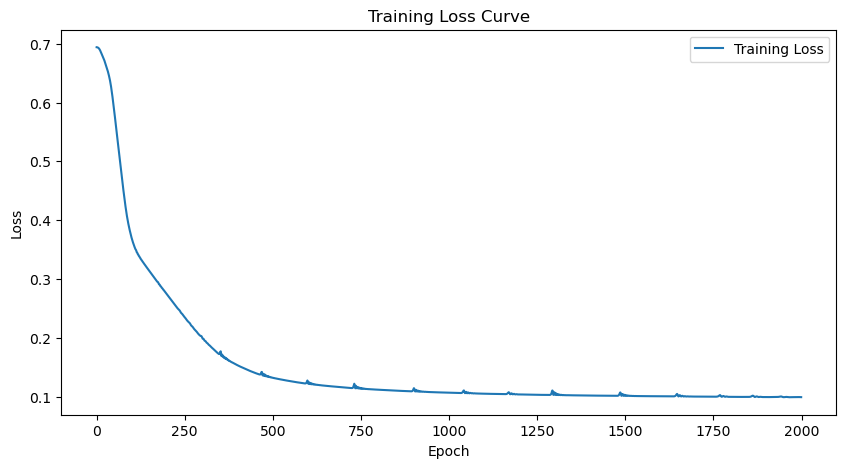

Final Model Accuracy: 81.84%
Final Model F1-score: 0.8262


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_0_layer.pth'.


In [11]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 81.84%
                  precision    recall  f1-score   support

    infringement       0.87      0.76      0.81       194
non_infringement       0.78      0.88      0.83       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.82      0.82      0.82       380



/tmp/ipykernel_314581/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
